# ML Task 1.5 Supervised learning algorithms - part 2 ANN - All Stations - REVISED

## Table of Contents

#### 01. Import libraries and datasets

#### 02. GridSearchCV

#### 03. Artificial Neural Network (ANN)

#### 04. Basel weather station ANN model results

#### 05. Reduce model overfitting: pivot to tensorflow/keras model building, regularization & training control

### 01. Import libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score

In [3]:
# Create path to dataset location
path = r'C:\Users\dirk8\CareerFoundry\07-2025 Machine Learning With Python\Datasets'

In [5]:
# Import the final transformed, split datasets from the "ML Task 1.5 part 2 - Basel - REVISED" jupyter notebook script.
X_train_reduced = pd.read_pickle(os.path.join(path, 'X_train_reduced.pkl'))
X_test = pd.read_pickle(os.path.join(path, 'X_test.pkl'))
y_train = pd.read_pickle(os.path.join(path, 'y_train.pkl'))
y_test = pd.read_pickle(os.path.join(path, 'y_test.pkl'))

In [7]:
# Check dimensions
print("X_train_reduced shape:", X_train_reduced.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train_reduced shape: (17211, 26)
y_train shape: (17211, 13)
X_test shape: (5738, 39)
y_test shape: (5738, 13)


In [9]:
X_train_reduced.head(2)

,BASEL_temp_mean,BASEL_temp_max,BELGRADE_temp_mean,BELGRADE_temp_max,BUDAPEST_temp_mean,BUDAPEST_temp_max,DEBILT_temp_mean,DEBILT_temp_max,DUSSELDORF_temp_mean,DUSSELDORF_temp_max,...,MADRID_temp_mean,MADRID_temp_max,MUNCHENB_temp_mean,MUNCHENB_temp_max,OSLO_temp_mean,OSLO_temp_max,SONNBLICK_temp_mean,SONNBLICK_temp_max,STOCKHOLM_temp_mean,STOCKHOLM_temp_max
DATE,,,,,,,,,,,,,,,,,,,,,
1982-05-04,-1.085876,-2.798598,0.899023,0.748243,2.146495,1.661393,-0.292950,-0.330847,0.863975,0.858822,...,-1.109096,-1.976637,0.803738,0.577551,1.116220,-0.07396,0.640783,0.363281,0.406228,-0.153647
2008-10-06,2.216577,0.902630,1.978051,1.718352,1.539823,2.167088,-0.146512,0.955457,0.561550,0.343457,...,0.844762,0.632403,2.181746,0.742598,0.515135,1.77206,2.002727,0.908343,0.270783,0.959359


In [11]:
X_train_reduced.tail(2)

,BASEL_temp_mean,BASEL_temp_max,BELGRADE_temp_mean,BELGRADE_temp_max,BUDAPEST_temp_mean,BUDAPEST_temp_max,DEBILT_temp_mean,DEBILT_temp_max,DUSSELDORF_temp_mean,DUSSELDORF_temp_max,...,MADRID_temp_mean,MADRID_temp_max,MUNCHENB_temp_mean,MUNCHENB_temp_max,OSLO_temp_mean,OSLO_temp_max,SONNBLICK_temp_mean,SONNBLICK_temp_max,STOCKHOLM_temp_mean,STOCKHOLM_temp_max
DATE,,,,,,,,,,,,,,,,,,,,,
1962-05-11,0.226057,0.060074,-1.402905,-1.552301,-2.846879,-1.228290,0.146364,0.477687,-0.432135,-0.378054,...,-0.052957,-0.553524,-0.421158,-0.467741,0.042854,0.479846,-1.121734,-1.271904,-0.225851,-0.844478
2003-04-01,-0.452529,1.143360,-2.374031,-2.245236,-1.820204,-1.408895,0.146364,0.220426,0.777568,0.687033,...,0.739148,0.909120,0.306124,1.320259,-0.644100,-1.661537,-0.520876,0.145256,0.090189,-0.230406


#### Comment: The imported files are the identical ones used in the final Decision Tree model fit tasks.  The raw temperature data series were 2-step transformed: first step was differencing, second step was z-score standardization using the StandardScaler function. The twice-transformed data series were confirmed as Stationary, using decomposition plots, ADF & KPSS tests and ACF plots.  The train/test-split datasets can be used now for the ANN model, they do not require further pre-processing.

### 02. GridSearchCV for ANN

#### Run a custom multi-label balanced accuracy scorer + GridSearchCV hyperparameter search to identify more effective model parameter combinations

In [20]:
# This code block trains one ANN for all weather stations at once, exactly matching our Decision Tree training setup
# Scores each model via 3-fold CV (cross-validation) using balanced accuracy across the multi-label outputs
# Keeps the grid search modest for speed purposes, but already explores ...
# ... network depth & width, nonlinearity type, solver type and regularization

import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

# 1) Make sure test features match reduced train features
X_test_reduced = X_test[X_train_reduced.columns]  # keep this for later evaluation

# 2) Custom scorer for multi-label (13 outputs)
def mean_balanced_accuracy_estimator(estimator, X, y_true):
    """
    Compute mean balanced accuracy across columns (stations) for a multi-label target.
    Robust to single-class folds (returns plain accuracy for that column in that case).
    """
    y_pred = estimator.predict(X)
    # ensure arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # if y_true is 1d (shouldn’t be), promote to 2d
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)

    scores = []
    for j in range(y_true.shape[1]):
        yt = y_true[:, j]
        yp = y_pred[:, j]
        # If only one class present in this fold, fall back to simple accuracy
        if np.unique(yt).size < 2:
            scores.append((yt == yp).mean())
        else:
            scores.append(balanced_accuracy_score(yt, yp))
    return float(np.mean(scores))

# 3) Define a compact, sensible grid (expand later if needed)
param_grid = {
    'hidden_layer_sizes': [(20,), (40,), (40, 20), (40, 20, 20)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [1e-4, 1e-3, 1e-2],  # L2 regularization
    # You can optionally add early stopping for adam:
    # 'early_stopping': [True, False]  # (lbfgs ignores it; GridSearch will still try)
}

mlp = MLPClassifier(max_iter=1000, random_state=42)

# 4) Use plain KFold (StratifiedKFold doesn't apply to multi-label matrix)
cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring=mean_balanced_accuracy_estimator,  # <-- custom scorer
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_reduced, y_train)

print("Best mean balanced accuracy (CV): {:.4f}".format(grid_search.best_score_))
print("Best params:", grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best mean balanced accuracy (CV): 0.6689
Best params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (40,), 'solver': 'lbfgs'}


C:\Users\dirk8\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### 03. Artificial Neural Network (ANN)

#### Fit the final ANN based on the best hyperparameters discovered subject to the grid values

In [23]:
from sklearn.neural_network import MLPClassifier

# Ensure test features match the reduced feature set
X_test_reduced = X_test[X_train_reduced.columns]

best_mlp = MLPClassifier(
    hidden_layer_sizes=(40,),
    activation='relu',
    solver='lbfgs',
    alpha=0.001,
    max_iter=3000,      # bump to avoid convergence warning on final fit
    random_state=42
)

best_mlp.fit(X_train_reduced, y_train)

C:\Users\dirk8\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(40,), max_iter=3000,
              random_state=42, solver='lbfgs')

### 04. Basel weather station ANN model results

#### Define custom per-station evaluation function

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def evaluate_ann_per_station(model, X_train, y_train_df, X_test, y_test_df, station_column):
    """
    Evaluate a multi-output ANN on a single station (column).
    Returns a metrics DataFrame (Train vs Test) and shows side-by-side confusion matrices.
    Handles single-class edge cases by passing labels=[0,1].
    """
    # Column index in the multi-output prediction
    col_idx = list(y_train_df.columns).index(station_column)

    # True labels
    y_train_true = y_train_df[station_column].astype(int).values
    y_test_true  = y_test_df[station_column].astype(int).values

    # Predict once and slice the column for efficiency
    y_train_pred_all = model.predict(X_train)
    y_test_pred_all  = model.predict(X_test)
    y_train_pred = y_train_pred_all[:, col_idx]
    y_test_pred  = y_test_pred_all[:, col_idx]

    def compute_metrics(y_true, y_pred, name):
        # Confusion matrix (force both labels to exist)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()

        # Metrics (Pleasant = 1, Unpleasant = 0)
        prec_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        rec_1  = recall_score(y_true, y_pred,    pos_label=1, zero_division=0)
        f1_1   = f1_score(y_true, y_pred,        pos_label=1, zero_division=0)

        prec_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)  # TN/(TN+FN)
        rec_0  = recall_score(y_true, y_pred,    pos_label=0, zero_division=0)  # TN/(TN+FP) = specificity

        balacc = balanced_accuracy_score(y_true, y_pred)
        overall = (tp + tn) / (tp + tn + fp + fn)

        return {
            "Dataset": name,
            "Overall Accuracy": overall,
            "Balanced Accuracy": balacc,
            "Pleasant Recall": rec_1,
            "Pleasant Precision": prec_1,
            "Pleasant F1": f1_1,
            "Unpleasant Recall (Specificity)": rec_0,
            "Unpleasant Precision": prec_0,
            "TP": tp, "FP": fp, "TN": tn, "FN": fn
        }

    train_row = compute_metrics(y_train_true, y_train_pred, "Train")
    test_row  = compute_metrics(y_test_true,  y_test_pred,  "Test")
    metrics_df = pd.DataFrame([train_row, test_row]).set_index("Dataset")

    # Confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    ConfusionMatrixDisplay.from_predictions(
        y_train_true, y_train_pred, labels=[0,1],
        display_labels=["Unpleasant","Pleasant"], cmap="Greens", ax=axes[0]
    )
    axes[0].set_title(f"Train CM — {station_column}")
    ConfusionMatrixDisplay.from_predictions(
        y_test_true, y_test_pred, labels=[0,1],
        display_labels=["Unpleasant","Pleasant"], cmap="Blues", ax=axes[1]
    )
    axes[1].set_title(f"Test CM — {station_column}")
    plt.tight_layout()
    plt.show()

    return metrics_df

#### Run the custom function on Basel weather station

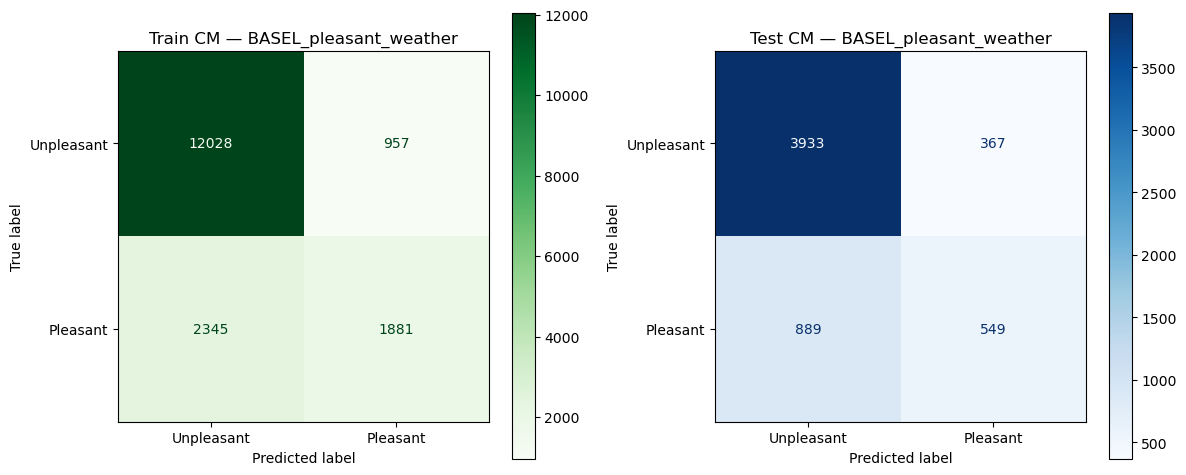

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.808146,0.685701,0.445102,0.662791,0.532559,0.926300,0.836847,1881,957,12028,2345
Test,0.781108,0.648216,0.381780,0.599345,0.466440,0.914651,0.815637,549,367,3933,889


In [33]:
metrics_basel_ann = evaluate_ann_per_station(
    model=best_mlp,
    X_train=X_train_reduced,
    y_train_df=y_train,
    X_test=X_test_reduced,
    y_test_df=y_test,
    station_column="BASEL_pleasant_weather"
)
metrics_basel_ann

#### Define custom learning curves plotting function

#### Learning curves for ANN (by sample size, per weather station)

##### Comment: Because lbfgs does not expose per-epoch loss, we can use sample-size learning curves as we did when plotting these for the DecisionTreeClassifier model.  This still helps with bias/variance diagnosis.

In [39]:
import numpy as np
from sklearn.model_selection import learning_curve

def ann_learning_curve_for_station(params, X, y_series, title_suffix=""):
    """
    Plot learning curve (balanced accuracy) for a single station label (y is 1-D).
    params: dict of MLPClassifier hyperparams (use best params).
    """
    y_vec = y_series.astype(int).values

    clf = MLPClassifier(
        **params,
        max_iter=3000,
        random_state=42
    )

    train_sizes, train_scores, val_scores = learning_curve(
        clf,
        X, y_vec,
        train_sizes=np.linspace(0.1, 1.0, 8),
        cv=3,
        scoring='balanced_accuracy',
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    tr_mean, tr_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    va_mean, va_std = val_scores.mean(axis=1),  val_scores.std(axis=1)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(9,6))
    plt.plot(train_sizes, tr_mean, 'o-', label='Training Balanced Acc')
    plt.fill_between(train_sizes, tr_mean-tr_std, tr_mean+tr_std, alpha=0.15)
    plt.plot(train_sizes, va_mean, 'o-', label='Validation Balanced Acc')
    plt.fill_between(train_sizes, va_mean-va_std, va_mean+va_std, alpha=0.15)
    plt.xlabel('Training Samples'); plt.ylabel('Balanced Accuracy')
    plt.title(f"ANN Learning Curve — {title_suffix}")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#### Run the custom function on Basel weather station

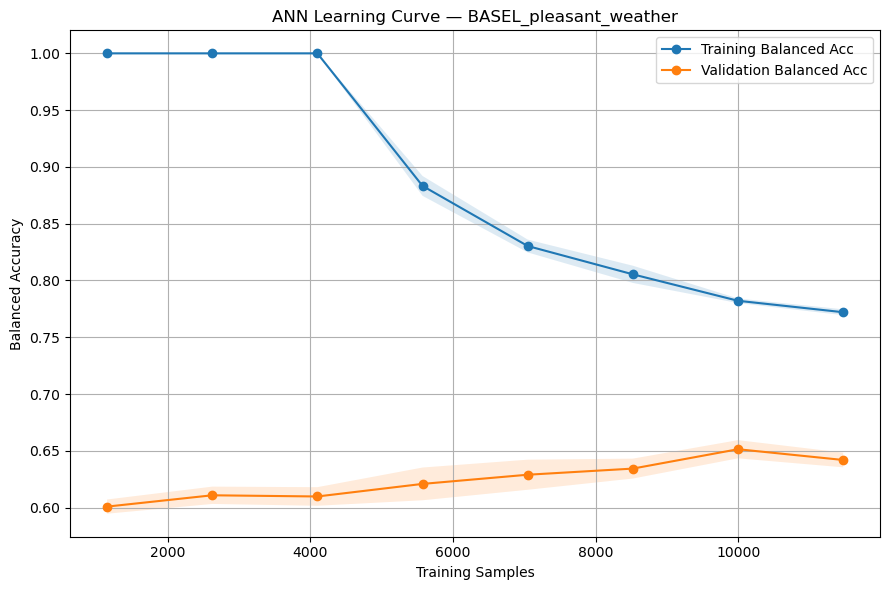

In [41]:
best_params = {
    'hidden_layer_sizes': (40,),
    'activation': 'relu',
    'solver': 'lbfgs',
    'alpha': 0.001
}
ann_learning_curve_for_station(
    best_params,
    X_train_reduced,                 # feature matrix
    y_train['BASEL_pleasant_weather'],
    title_suffix="BASEL_pleasant_weather"
)

## "Houston, we have a problem": severe overfitting as per the final gap between train and test (validation) curves, including an anemic learning ascent line for test.  Consequently, since we are "feature-constrained" by our coursework (at this stage) to only using temperature features as inputs to ML models to classify Unpleasant/Pleasant day outcomes, we will go a different route to try to tame the severe learning curve gap which visually appears to be ~ 13% (this much requires intervention).  Keras ANN with L2 + Dropout + Adam.  We bid adieu to the lbfgs solver.

### 05. Reduce model overfitting: pivot to tensorflow/keras model building, regularization & training control

#### Import libraries

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Ensure X_test matches the reduced feature set used for training
X_test_reduced = X_test[X_train_reduced.columns]

#### Model factory: Keras ANN with L2 + Dropout + Adam

In [51]:
def build_ann(input_dim, hidden_units=(40,), dropout=0.3, l2_alpha=1e-3, lr=1e-3):
    model = keras.Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(layers.Dense(units, activation='relu',
                                   kernel_regularizer=regularizers.l2(l2_alpha),
                                   input_shape=(input_dim,)))
        else:
            model.add(layers.Dense(units, activation='relu',
                                   kernel_regularizer=regularizers.l2(l2_alpha)))
        model.add(layers.Dropout(dropout))
    # 13 outputs (one per station), sigmoid for multi-label
    model.add(layers.Dense( y_train.shape[1], activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy'
    )
    return model

#### Quick validation split (so we can score balanced accuracy)

In [54]:
# 10% validation split from the train set to pick hyperparameters
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_reduced, y_train, test_size=0.10, random_state=42, shuffle=True
)

#### Small hyperparameter sweep (alpha, dropout, width/depth)

In [57]:
param_grid = [
    {"hidden_units": (40,),     "dropout": 0.2, "l2": 1e-3, "lr": 1e-3},
    {"hidden_units": (40,20),   "dropout": 0.2, "l2": 1e-3, "lr": 1e-3},
    {"hidden_units": (40,),     "dropout": 0.4, "l2": 1e-3, "lr": 1e-3},
    {"hidden_units": (40,20),   "dropout": 0.4, "l2": 1e-3, "lr": 1e-3},

    {"hidden_units": (40,),     "dropout": 0.2, "l2": 1e-2, "lr": 1e-3},
    {"hidden_units": (40,20),   "dropout": 0.2, "l2": 1e-2, "lr": 1e-3},
    {"hidden_units": (40,),     "dropout": 0.4, "l2": 1e-2, "lr": 1e-3},
    {"hidden_units": (40,20),   "dropout": 0.4, "l2": 1e-2, "lr": 1e-3},
]

def mean_bal_acc(y_true_bin, y_pred_prob, thresh=0.5):
    y_pred = (y_pred_prob >= thresh).astype(int)
    # mean balanced accuracy across the 13 columns
    scores = []
    for j in range(y_true_bin.shape[1]):
        yt, yp = y_true_bin[:, j], y_pred[:, j]
        if len(np.unique(yt)) < 2:
            scores.append((yt == yp).mean())  # fallback to accuracy if single-class
        else:
            scores.append(balanced_accuracy_score(yt, yp))
    return float(np.mean(scores))

best_cfg, best_score = None, -np.inf
histories = {}

for cfg in param_grid:
    tf.keras.backend.clear_session()
    model = build_ann(
        input_dim=X_tr.shape[1],
        hidden_units=cfg["hidden_units"],
        dropout=cfg["dropout"],
        l2_alpha=cfg["l2"],
        lr=cfg["lr"]
    )
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
        )
    ]
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=256,
        verbose=0,
        callbacks=callbacks
    )
    histories[str(cfg)] = history.history

    # Score on validation (balanced accuracy)
    val_probs = model.predict(X_val, verbose=0)
    val_score = mean_bal_acc(y_val.values.astype(int), val_probs, thresh=0.5)

    if val_score > best_score:
        best_score = val_score
        best_cfg = cfg
        best_weights = model.get_weights()

print("Best validation mean Balanced Accuracy: {:.4f}".format(best_score))
print("Best config:", best_cfg)

C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs

Best validation mean Balanced Accuracy: 0.6186
Best config: {'hidden_units': (40,), 'dropout': 0.2, 'l2': 0.001, 'lr': 0.001}


#### Refit full model with best configuration

In [60]:
best_cfg = {'hidden_units': (40,), 'dropout': 0.2, 'l2': 1e-3, 'lr': 1e-3}

tf.keras.backend.clear_session()
best_model = build_ann(
    input_dim=X_train_reduced.shape[1],
    hidden_units=best_cfg["hidden_units"],
    dropout=best_cfg["dropout"],
    l2_alpha=best_cfg["l2"],
    lr=best_cfg["lr"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

history_full = best_model.fit(
    X_train_reduced, y_train,
    validation_split=0.10,
    epochs=300,
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/300


C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6816 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5689 - val_loss: 0.5227 - learning_rate: 0.0010
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5354 - val_loss: 0.5037 - learning_rate: 0.0010
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5184 - val_loss: 0.4920 - learning_rate: 0.0010
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5063 - val_loss: 0.4838 - learning_rate: 0.0010
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4985 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4912 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 8/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4853 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 9/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4806 - val_loss: 0.4638 - learning_rate: 0.0010
Epoch 10/300
61/61 ━━━━━━━━━━━━

#### Plot the epoch curves (train vs validation loss) to eyeball the gap

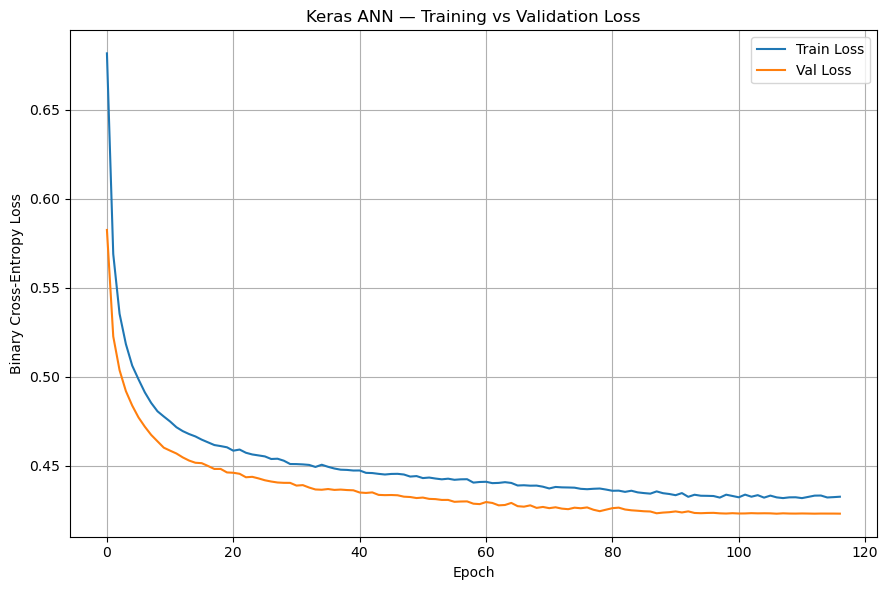

In [63]:
plt.figure(figsize=(9,6))
plt.plot(history_full.history['loss'], label='Train Loss')
plt.plot(history_full.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Keras ANN — Training vs Validation Loss')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#### Moving in the right direction, stable, small gap.

#### Define custom function for per-station evaluation (similar approach as the Decision Tree exercise) -- but, Keras edition

In [70]:
def evaluate_keras_per_station(model, X_train, y_train_df, X_test, y_test_df, station_column, thresh=0.5):
    col_idx = list(y_train_df.columns).index(station_column)

    # Predict probabilities once
    train_probs = model.predict(X_train, verbose=0)
    test_probs  = model.predict(X_test,  verbose=0)
    y_train_pred = (train_probs[:, col_idx] >= thresh).astype(int)
    y_test_pred  = (test_probs[:,  col_idx] >= thresh).astype(int)

    y_train_true = y_train_df[station_column].astype(int).values
    y_test_true  = y_test_df[station_column].astype(int).values

    def compute(y_true, y_pred, name):
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()

        prec_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        rec_1  = recall_score(y_true, y_pred,    pos_label=1, zero_division=0)
        f1_1   = f1_score(y_true, y_pred,        pos_label=1, zero_division=0)

        prec_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
        rec_0  = recall_score(y_true, y_pred,    pos_label=0, zero_division=0)

        balacc = balanced_accuracy_score(y_true, y_pred)
        overall = (tp + tn) / (tp + tn + fp + fn)

        return {
            "Dataset": name,
            "Overall Accuracy": overall,
            "Balanced Accuracy": balacc,
            "Pleasant Recall": rec_1,
            "Pleasant Precision": prec_1,
            "Pleasant F1": f1_1,
            "Unpleasant Recall (Specificity)": rec_0,
            "Unpleasant Precision": prec_0,
            "TP": tp, "FP": fp, "TN": tn, "FN": fn
        }

    train_row = compute(y_train_true, y_train_pred, "Train")
    test_row  = compute(y_test_true,  y_test_pred,  "Test")
    metrics_df = pd.DataFrame([train_row, test_row]).set_index("Dataset")

    # Confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    ConfusionMatrixDisplay.from_predictions(
        y_train_true, y_train_pred, labels=[0,1],
        display_labels=["Unpleasant","Pleasant"], cmap="Greens", ax=axes[0]
    ); axes[0].set_title(f"Train CM — {station_column}")
    ConfusionMatrixDisplay.from_predictions(
        y_test_true, y_test_pred, labels=[0,1],
        display_labels=["Unpleasant","Pleasant"], cmap="Blues", ax=axes[1]
    ); axes[1].set_title(f"Test CM — {station_column}")
    plt.tight_layout(); plt.show()

    return metrics_df

#### Evaluate Basel weather station with the Keras evaluate function

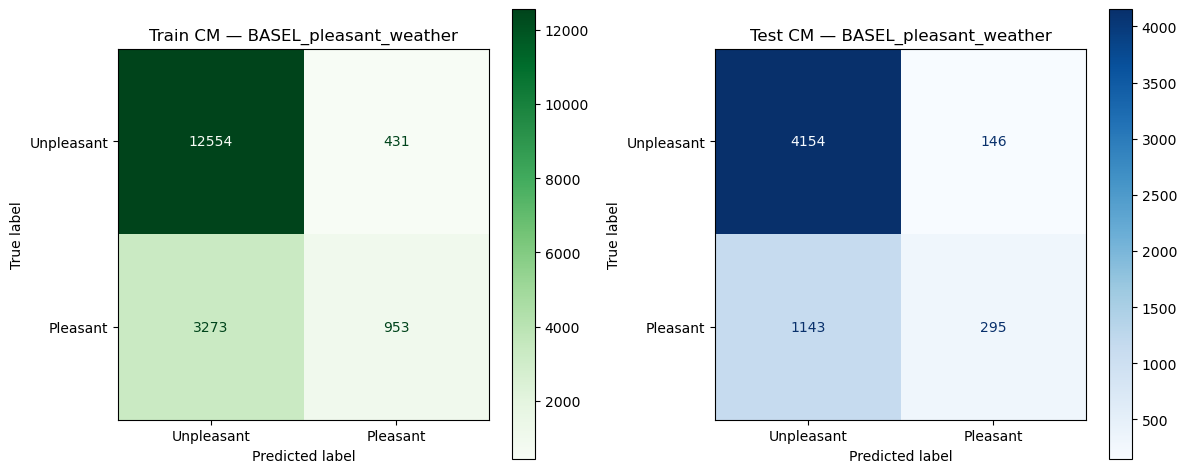

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.784789,0.596158,0.225509,0.688584,0.339750,0.966808,0.793201,953,431,12554,3273
Test,0.775357,0.585596,0.205146,0.668934,0.313997,0.966047,0.784217,295,146,4154,1143


In [72]:
X_test_reduced = X_test[X_train_reduced.columns]

keras_metrics_basel = evaluate_keras_per_station(
    best_model,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="BASEL_pleasant_weather",
    thresh=0.5
)
keras_metrics_basel

#### Comment: Model over-regularized, not what we wanted, focusing too much on Unpleasant accuracy, at the expense of Pleasant, the minority class. Further adjustments needed.

#### Helpers -- metrics + per-label sample weights (multi-label)

In [76]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import balanced_accuracy_score, recall_score

def mean_bal_acc(y_true_bin, y_pred_prob, thresh=0.5):
    y_pred = (y_pred_prob >= thresh).astype(int)
    scores = []
    for j in range(y_true_bin.shape[1]):
        yt, yp = y_true_bin[:, j], y_pred[:, j]
        if np.unique(yt).size < 2:
            scores.append((yt == yp).mean())
        else:
            scores.append(balanced_accuracy_score(yt, yp))
    return float(np.mean(scores))

def mean_pleasant_recall(y_true_bin, y_pred_prob, thresh=0.5):
    y_pred = (y_pred_prob >= thresh).astype(int)
    recalls = []
    for j in range(y_true_bin.shape[1]):
        yt, yp = y_true_bin[:, j], y_pred[:, j]
        if (yt == 1).any():  # skip columns with no positives
            recalls.append(recall_score(yt, yp, pos_label=1, zero_division=0))
    return float(np.mean(recalls)) if len(recalls) else 0.0

def make_sample_weights(Y, cap=10.0):
    """
    Returns (N, K) sample_weight matrix for multi-label BCE.
    For each column k: positives get weight w_pos = n_neg / max(n_pos,1) (capped),
    negatives get 1.0
    """
    Y = np.asarray(Y, dtype=int)
    N, K = Y.shape
    W = np.ones((N, K), dtype=float)
    pos = Y.sum(axis=0)
    neg = N - pos
    w_pos = np.divide(neg, np.clip(pos, 1, None))   # neg/pos
    w_pos = np.clip(w_pos, 1.0, cap)
    for k in range(K):
        W[:, k] = np.where(Y[:, k] == 1, w_pos[k], 1.0)
    return W

#### Build model (Input()-style), same as earlier

In [80]:
from tensorflow.keras import layers, regularizers

def build_ann(input_dim, hidden_units=(40,), dropout=0.2, l2_alpha=1e-3, lr=1e-3):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for units in hidden_units:
        x = layers.Dense(units, activation='relu',
                         kernel_regularizer=regularizers.l2(l2_alpha))(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(y_train.shape[1], activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy')
    return model

#### Prepare train/validation split + per-label sample weights

In [83]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_reduced, y_train, test_size=0.10, random_state=42, shuffle=True
)

sw_tr  = make_sample_weights(y_tr.values)   # (N_tr, 13)
sw_val = make_sample_weights(y_val.values)  # (N_val, 13)

#### Micro-sweep on (l2, dropout) with sample_weight

In [86]:
def score_config(hidden_units, dropout, l2, lr=1e-3, epochs=250, batch_size=256):
    tf.keras.backend.clear_session()
    model = build_ann(
        input_dim=X_tr.shape[1],
        hidden_units=hidden_units,
        dropout=dropout,
        l2_alpha=l2,
        lr=lr
    )
    cbs = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
    ]
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val, sw_val),
        sample_weight=sw_tr,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=cbs
    )

    tr_prob = model.predict(X_tr,  verbose=0)
    val_prob= model.predict(X_val, verbose=0)
    tr_ba   = mean_bal_acc(y_tr.values.astype(int),  tr_prob)
    val_ba  = mean_bal_acc(y_val.values.astype(int), val_prob)
    val_rec = mean_pleasant_recall(y_val.values.astype(int), val_prob)
    gap     = tr_ba - val_ba

    return {
        "hidden_units": hidden_units,
        "dropout": dropout,
        "l2": l2,
        "val_bal_acc": val_ba,
        "train_bal_acc": tr_ba,
        "val_pleasant_recall": val_rec,
        "gap": gap,
        "history": hist.history
    }

l2_list   = [1e-4, 5e-4, 1e-3]
drop_list = [0.1, 0.2]
hidden    = (40,)

results = []
for l2 in l2_list:
    for dp in drop_list:
        res = score_config(hidden, dp, l2)
        results.append(res)
        print(f"l2={l2:.0e}, dropout={dp:.1f} | "
              f"val BA={res['val_bal_acc']:.4f}, "
              f"PleasRec={res['val_pleasant_recall']:.4f}, "
              f"gap={100*res['gap']:.1f}%")

leader = pd.DataFrame([
    {k: r[k] for k in ["l2","dropout","val_bal_acc","val_pleasant_recall","train_bal_acc","gap"]}
    for r in results
]).sort_values(
    by=["val_bal_acc","val_pleasant_recall","gap"],
    ascending=[False, True, True]  # prefer higher BA, then higher recall, then smaller gap
)
leader

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/binary_crossentropy/mul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\dirk8\anaconda3\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\dirk8\anaconda3\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\dirk8\anaconda3\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code

  File "C:\Users\dirk8\AppData\Local\Temp\ipykernel_15172\1994306429.py", line 49, in <module>

  File "C:\Users\dirk8\AppData\Local\Temp\ipykernel_15172\1994306429.py", line 14, in score_config

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 61, in train_step

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\trainers\trainer.py", line 383, in _compute_loss

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\trainers\trainer.py", line 351, in compute_loss

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 690, in __call__

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 699, in call

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\losses\loss.py", line 79, in __call__

  File "C:\Users\dirk8\anaconda3\Lib\site-packages\keras\src\losses\loss.py", line 190, in reduce_weighted_values

Incompatible shapes: [256,13] vs. [256]
	 [[{{node compile_loss/binary_crossentropy/mul}}]] [Op:__inference_multi_step_on_iterator_345117]

#### Quick fix for incompatible matrix shapes

In [89]:
import numpy as np

def make_sample_weights_1d(Y, cap=10.0):
    """
    Returns (N,) sample_weight vector for multi-label BCE.
    If a sample has positives, weight = mean of per-label pos-weights for the active labels.
    If no positives, weight = 1.0
    """
    Y = np.asarray(Y, dtype=int)
    N, K = Y.shape
    pos = Y.sum(axis=0)
    neg = N - pos
    w_pos = np.divide(neg, np.clip(pos, 1, None))   # pos weight per label
    w_pos = np.clip(w_pos, 1.0, cap)

    sw = np.ones(N, dtype=float)
    has_pos = Y.sum(axis=1) > 0
    # avoid division by zero: for rows with positives, average the weights of the positive labels
    pos_sums = (Y * w_pos).sum(axis=1)
    counts   = np.clip(Y.sum(axis=1), 1, None)
    sw[has_pos] = pos_sums[has_pos] / counts[has_pos]
    return sw

# Build 1D weights
sw_tr  = make_sample_weights_1d(y_tr.values, cap=10.0)
# No need to weight validation for early stopping

#### Next, update the training call in the micro-sweep

In [92]:
def score_config(hidden_units, dropout, l2, lr=1e-3, epochs=250, batch_size=256):
    tf.keras.backend.clear_session()
    model = build_ann(
        input_dim=X_tr.shape[1],
        hidden_units=hidden_units,
        dropout=dropout,
        l2_alpha=l2,
        lr=lr
    )
    cbs = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
    ]
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),   # <-- no val weights
        sample_weight=sw_tr,              # <-- 1D weights
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=cbs
    )

    tr_prob = model.predict(X_tr,  verbose=0)
    val_prob= model.predict(X_val, verbose=0)
    tr_ba   = mean_bal_acc(y_tr.values.astype(int),  tr_prob)
    val_ba  = mean_bal_acc(y_val.values.astype(int), val_prob)
    val_rec = mean_pleasant_recall(y_val.values.astype(int), val_prob)
    gap     = tr_ba - val_ba

    return {
        "hidden_units": hidden_units,
        "dropout": dropout,
        "l2": l2,
        "val_bal_acc": val_ba,
        "train_bal_acc": tr_ba,
        "val_pleasant_recall": val_rec,
        "gap": gap,
        "history": hist.history
    }

#### Define the tiny grid and run the micro-sweep

In [95]:
# --- 1) Define a small grid and run the sweep ---
l2_list   = [1e-4, 5e-4, 1e-3]   # lighter L2 (we were over-regularizing)
drop_list = [0.1, 0.2]           # lighter dropout
hidden    = (40,)                # keep width the same

results = []
for l2 in l2_list:
    for dp in drop_list:
        res = score_config(hidden_units=hidden, dropout=dp, l2=l2)
        results.append(res)
        print(f"l2={l2:.0e}, dropout={dp:.1f} | "
              f"val BA={res['val_bal_acc']:.4f}, "
              f"PleasRec={res['val_pleasant_recall']:.4f}, "
              f"gap={100*res['gap']:.1f}%")

# Build a small leaderboard: prefer higher val BA, then higher Pleasant recall, then smaller gap
leader = pd.DataFrame([
    {k: r[k] for k in ["l2","dropout","val_bal_acc","val_pleasant_recall","train_bal_acc","gap"]}
    for r in results
]).sort_values(by=["val_bal_acc","val_pleasant_recall","gap"],
              ascending=[False, True, True])

leader

l2=1e-04, dropout=0.1 | val BA=0.6746, PleasRec=0.4318, gap=0.2%
l2=1e-04, dropout=0.2 | val BA=0.6718, PleasRec=0.4293, gap=-0.0%
l2=5e-04, dropout=0.1 | val BA=0.6699, PleasRec=0.4257, gap=0.4%
l2=5e-04, dropout=0.2 | val BA=0.6730, PleasRec=0.4295, gap=0.1%
l2=1e-03, dropout=0.1 | val BA=0.6767, PleasRec=0.4414, gap=0.4%
l2=1e-03, dropout=0.2 | val BA=0.6660, PleasRec=0.4165, gap=0.1%


,l2,dropout,val_bal_acc,val_pleasant_recall,train_bal_acc,gap
4,0.0010,0.1,0.676690,0.441396,0.680377,0.003688
0,0.0001,0.1,0.674578,0.431770,0.676576,0.001999
3,0.0005,0.2,0.672960,0.429493,0.674074,0.001114
1,0.0001,0.2,0.671760,0.429293,0.671687,-0.000072
2,0.0005,0.1,0.669879,0.425706,0.673900,0.004021
5,0.0010,0.2,0.666040,0.416457,0.666949,0.000909


#### Use the best configuration (first line from the table above) to refit model on full train dataset. For the best configuration, we prefer a higher-value Balanced Accuracy score, then higher Pleasant Recall, then a smaller gap.

In [98]:
# Pick the best row from the leader df (it looks like index 4)
best_row = leader.iloc[0]  # if row 4 is top after sorting, this will already be it
best_cfg_fine = {
    "hidden_units": (40,),
    "dropout": float(best_row["dropout"]),   # 0.1
    "l2": float(best_row["l2"]),             # 1e-3
    "lr": 1e-3
}
print("Best cfg (weighted):", best_cfg_fine)

tf.keras.backend.clear_session()
best_model_fine = build_ann(
    input_dim=X_train_reduced.shape[1],
    hidden_units=best_cfg_fine["hidden_units"],
    dropout=best_cfg_fine["dropout"],
    l2_alpha=best_cfg_fine["l2"],
    lr=best_cfg_fine["lr"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
]

# 1D sample weights on FULL training set
sw_full = make_sample_weights_1d(y_train.values, cap=10.0)

history_full_fine = best_model_fine.fit(
    X_train_reduced, y_train,
    validation_split=0.10,
    epochs=300,
    batch_size=256,
    verbose=1,
    sample_weight=sw_full,
    callbacks=callbacks
)

Best cfg (weighted): {'hidden_units': (40,), 'dropout': 0.1, 'l2': 0.001, 'lr': 0.001}
Epoch 1/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3616 - val_loss: 1.2226 - learning_rate: 0.0010
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2305 - val_loss: 1.1637 - learning_rate: 0.0010
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1950 - val_loss: 1.1412 - learning_rate: 0.0010
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1751 - val_loss: 1.1269 - learning_rate: 0.0010
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1612 - val_loss: 1.1169 - learning_rate: 0.0010
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1492 - val_loss: 1.1077 - learning_rate: 0.0010
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1396 - val_loss: 1.1014 - learning_rate: 0.0010
Epoch 8/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1313 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 9/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s

#### Evaluate Basel weather station with the Keras evaluate function

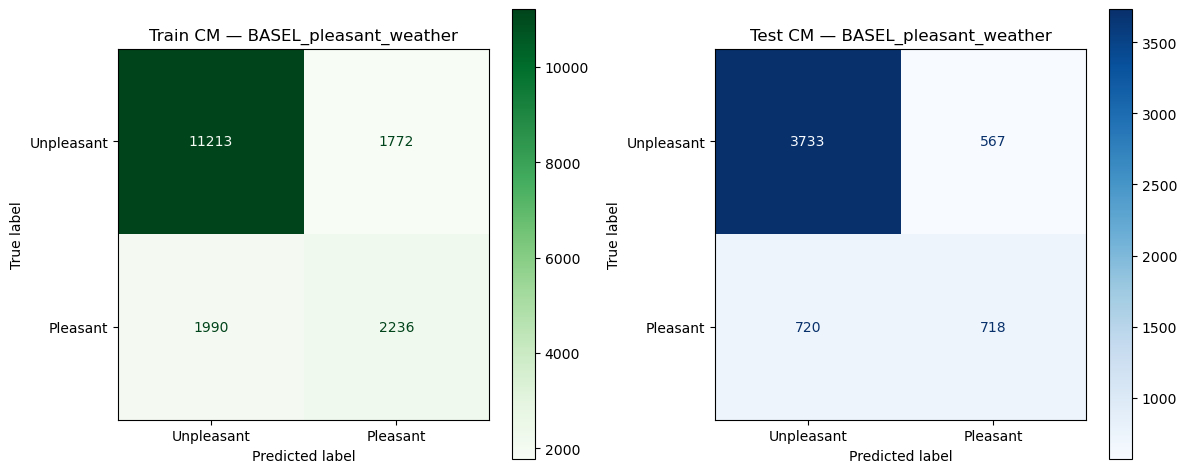

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.781419,0.696320,0.529106,0.557884,0.543114,0.863535,0.849277,2236,1772,11213,1990
Test,0.775706,0.683722,0.499305,0.558755,0.527360,0.868140,0.838311,718,567,3733,720


In [102]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_basel_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="BASEL_pleasant_weather",
    thresh=0.5
)
keras_metrics_basel_weighted

#### Define train/test learning curves custom plotting function

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

def plot_keras_learning_curve_station(
    X, y_df, station_col, build_params,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3, epochs=250, batch_size=256, random_state=42
):
    """
    Learning curve for one station (column) using Balanced Accuracy.
    - X: feature matrix (pandas DataFrame or ndarray)
    - y_df: multi-label targets (DataFrame, 13 cols)
    - station_col: e.g., "BASEL_pleasant_weather"
    - build_params: dict for build_ann (hidden_units, dropout, l2_alpha, lr)
    """
    rng = np.random.RandomState(random_state)
    y_station = y_df[station_col].astype(int).values
    X_arr = np.asarray(X)
    y_all = y_df.values.astype(int)

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    tr_means, tr_stds, va_means, va_stds, sizes = [], [], [], [], []

    for frac in train_sizes:
        tr_scores, va_scores = [], []

        for train_idx, val_idx in skf.split(X_arr, y_station):
            # Full fold split
            X_tr_full, y_tr_full = X_arr[train_idx], y_all[train_idx]
            X_va,     y_va       = X_arr[val_idx],   y_all[val_idx]

            # Subsample the training fold to the requested fraction
            n_sub = max(200, int(len(train_idx) * frac))
            perm = rng.permutation(len(train_idx))[:n_sub]
            X_tr = X_tr_full[perm]
            y_tr = y_tr_full[perm]

            # Sample weights (1D) for imbalance
            sw_tr = make_sample_weights_1d(y_tr, cap=10.0)

            # Build & train model
            tf.keras.backend.clear_session()
            model = build_ann(
                input_dim=X_tr.shape[1],
                hidden_units=build_params["hidden_units"],
                dropout=build_params["dropout"],
                l2_alpha=build_params["l2"],
                lr=build_params.get("lr", 1e-3)
            )
            cbs = [
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
            ]
            model.fit(
                X_tr, y_tr,
                validation_split=0.10,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                sample_weight=sw_tr,
                callbacks=cbs
            )

            # Scores (Balanced Accuracy) on sub-train and fold-validation
            tr_prob = model.predict(X_tr, verbose=0)
            va_prob = model.predict(X_va, verbose=0)
            tr_ba = mean_bal_acc(y_tr, tr_prob)
            va_ba = mean_bal_acc(y_va, va_prob)

            tr_scores.append(tr_ba)
            va_scores.append(va_ba)

        sizes.append(int(len(X_arr) * frac))
        tr_means.append(np.mean(tr_scores)); tr_stds.append(np.std(tr_scores))
        va_means.append(np.mean(va_scores)); va_stds.append(np.std(va_scores))

    # Plot
    sizes = np.array(sizes)
    tr_means, tr_stds = np.array(tr_means), np.array(tr_stds)
    va_means, va_stds = np.array(va_means), np.array(va_stds)

    plt.figure(figsize=(10,6))
    plt.plot(sizes, tr_means, 'o-', label='Training Balanced Acc')
    plt.fill_between(sizes, tr_means-tr_stds, tr_means+tr_stds, alpha=0.15)
    plt.plot(sizes, va_means, 'o-', label='Validation Balanced Acc')
    plt.fill_between(sizes, va_means-va_stds, va_means+va_stds, alpha=0.15)
    plt.xlabel('Training Samples'); plt.ylabel('Balanced Accuracy')
    plt.title(f'ANN Learning Curve — {station_col}')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return {
        "sizes": sizes,
        "train_mean": tr_means, "train_std": tr_stds,
        "val_mean": va_means,   "val_std": va_stds
    }

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

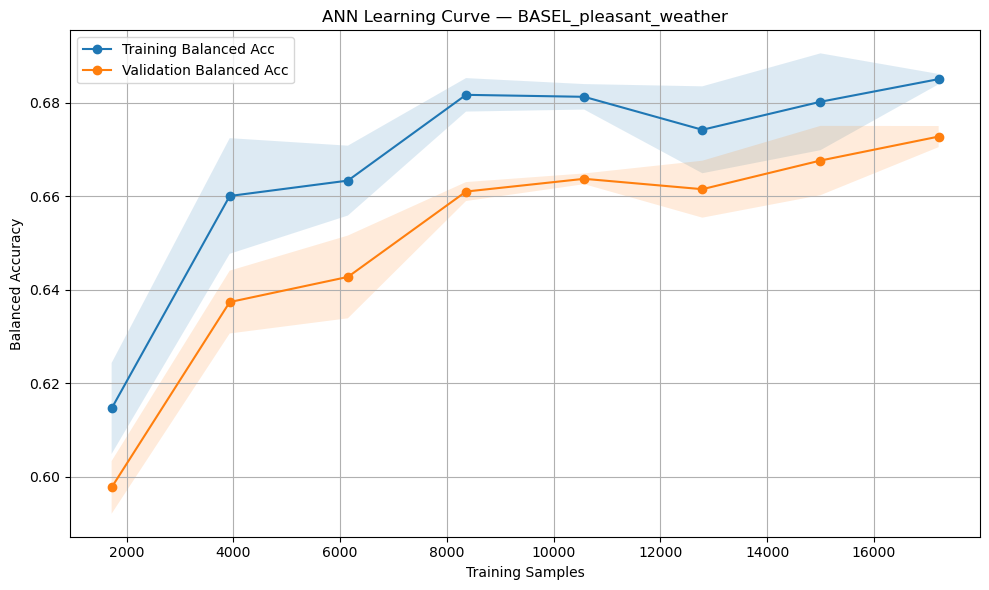

In [108]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="BASEL_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

### Comment: Finally, this is a good result for Basel. The gaps between different metrics (in the table further above, below the confusion matrices) have been reduced, aiming to balance different types of performance better.  Meanwhile, the train/validation (test) learning curves show a very small final gap, and trend up, mostly parallel moves as number of training samples increases.  Model inputs and parameters will now be rolled out to the other weather stations.

#### Evaluate Oslo weather station with the Keras evaluate function

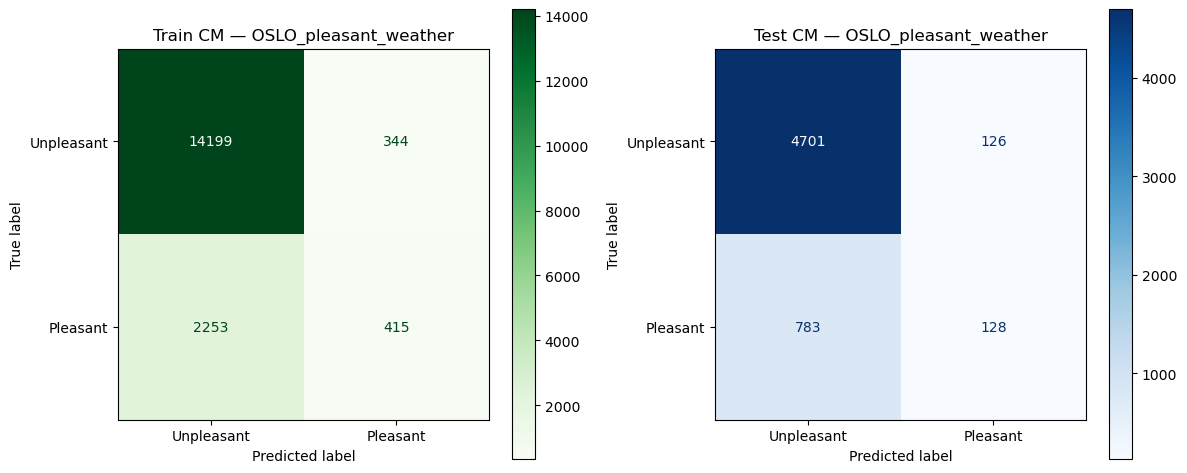

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.849108,0.565947,0.155547,0.546772,0.242194,0.976346,0.863056,415,344,14199,2253
Test,0.841582,0.557201,0.140505,0.503937,0.219742,0.973897,0.857221,128,126,4701,783


In [112]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_oslo_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="OSLO_pleasant_weather",
    thresh=0.5
)
keras_metrics_oslo_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

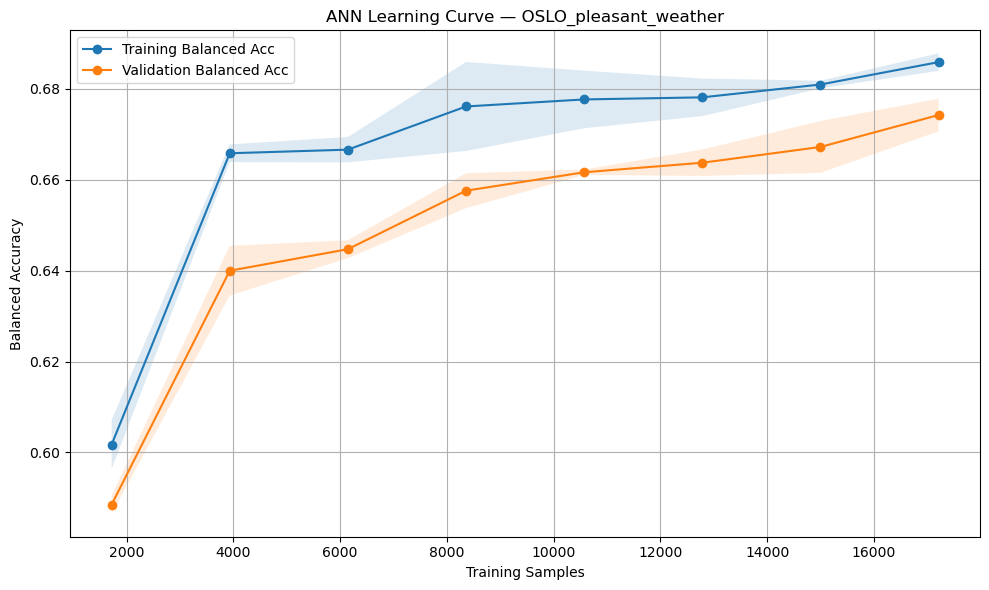

In [117]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="OSLO_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Stockholm weather station with the Keras evaluate function

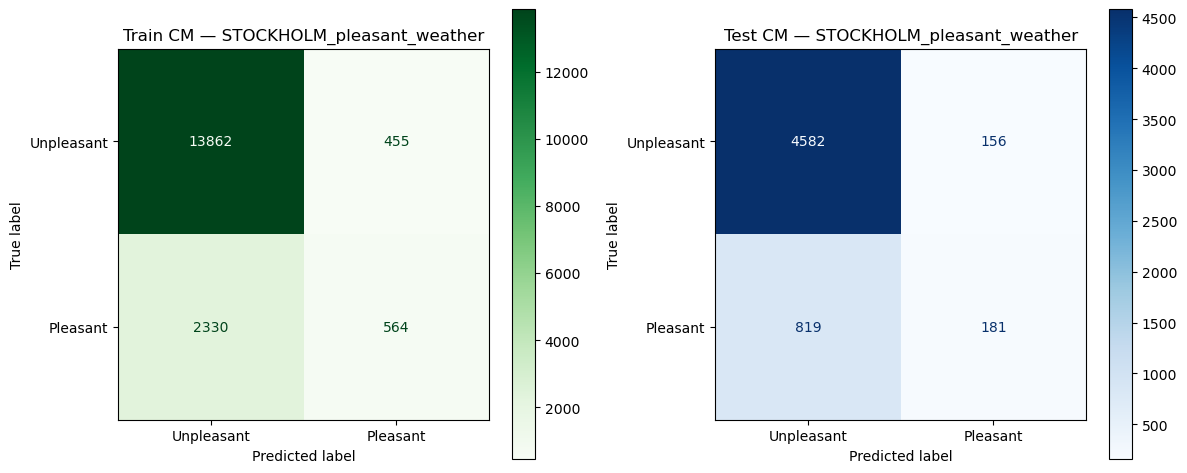

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.838185,0.581553,0.194886,0.553484,0.288270,0.968220,0.856102,564,455,13862,2330
Test,0.830080,0.574037,0.181000,0.537092,0.270755,0.967075,0.848361,181,156,4582,819


In [119]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_stockholm_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="STOCKHOLM_pleasant_weather",
    thresh=0.5
)
keras_metrics_stockholm_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

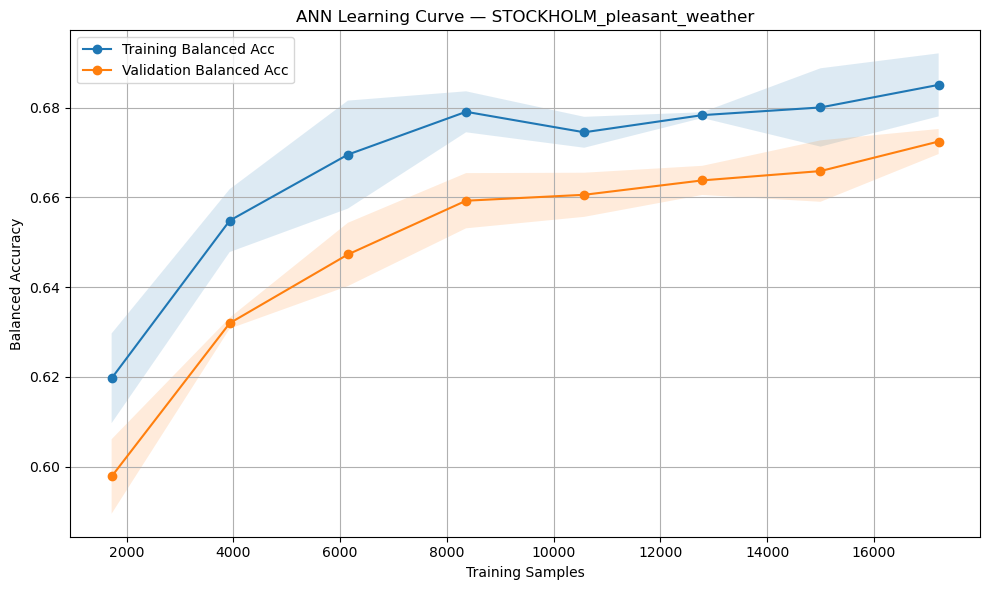

In [122]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="STOCKHOLM_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Budapest weather station with the Keras evaluate function

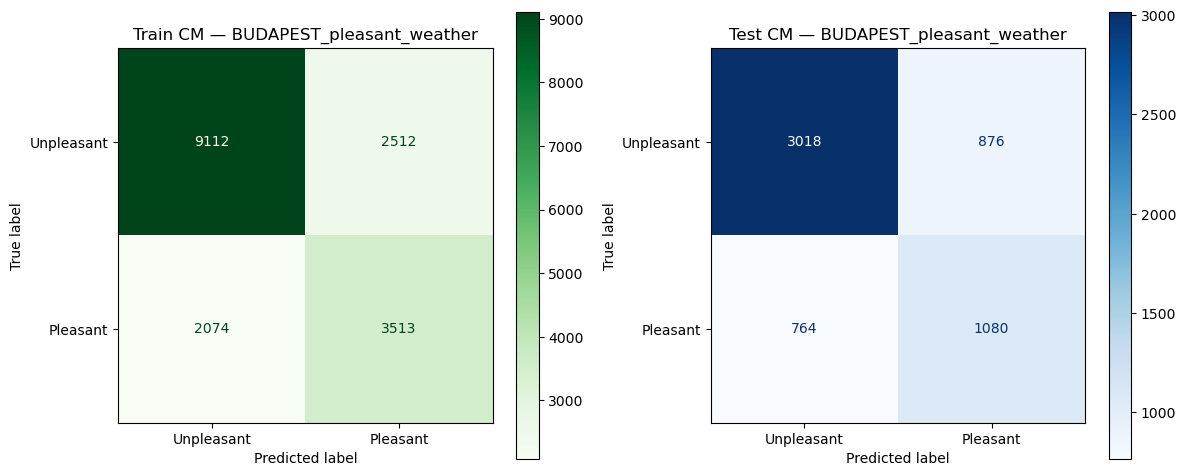

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.733543,0.706338,0.628781,0.583071,0.605064,0.783895,0.81459,3513,2512,9112,2074
Test,0.714186,0.680361,0.585683,0.552147,0.568421,0.775039,0.79799,1080,876,3018,764


In [124]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_budapest_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="BUDAPEST_pleasant_weather",
    thresh=0.5
)
keras_metrics_budapest_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

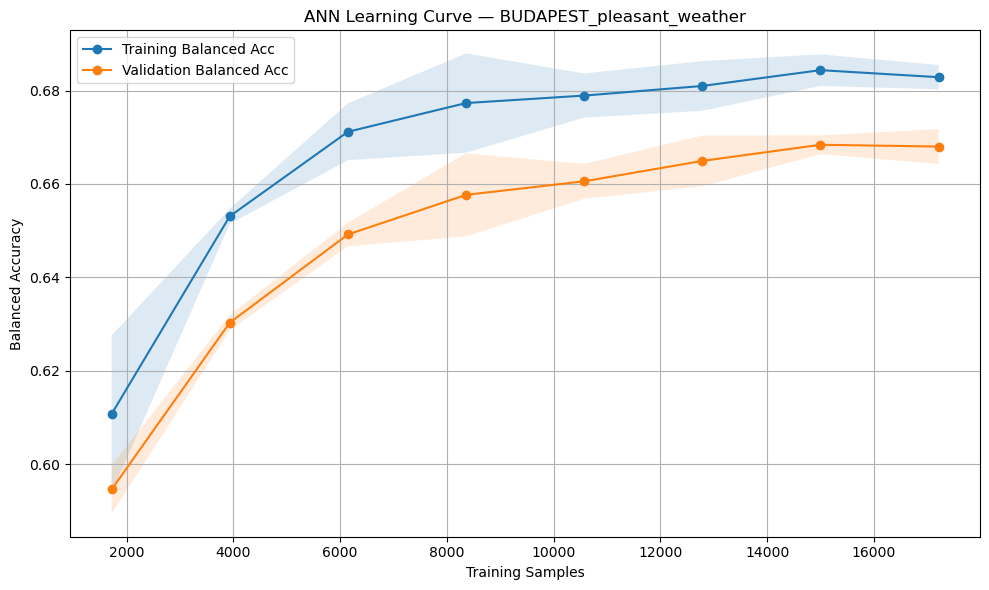

In [127]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="BUDAPEST_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Debilt weather station with the Keras evaluate function

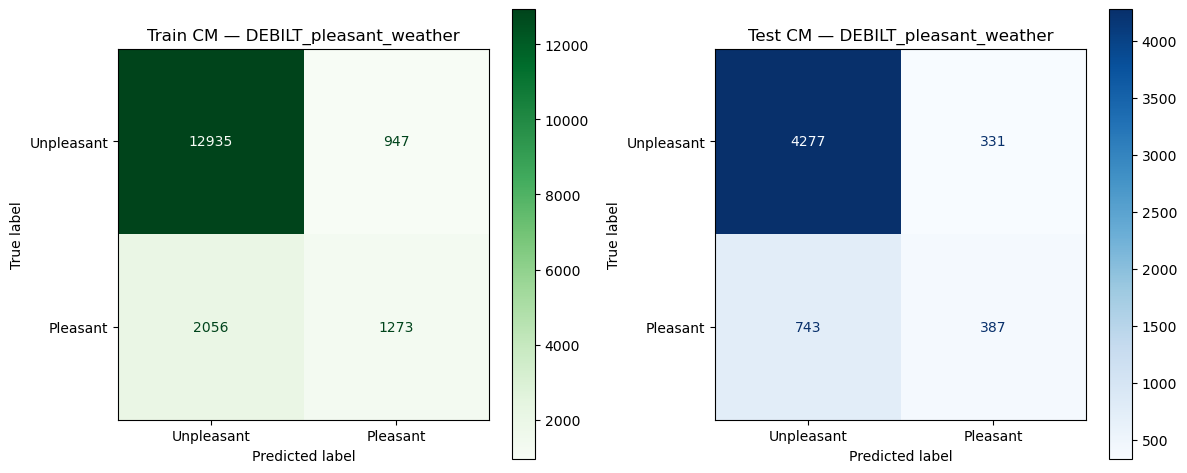

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.825519,0.657090,0.382397,0.573423,0.458821,0.931782,0.862851,1273,947,12935,2056
Test,0.812827,0.635323,0.342478,0.538997,0.418831,0.928168,0.851992,387,331,4277,743


In [130]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_debilt_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="DEBILT_pleasant_weather",
    thresh=0.5
)
keras_metrics_debilt_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

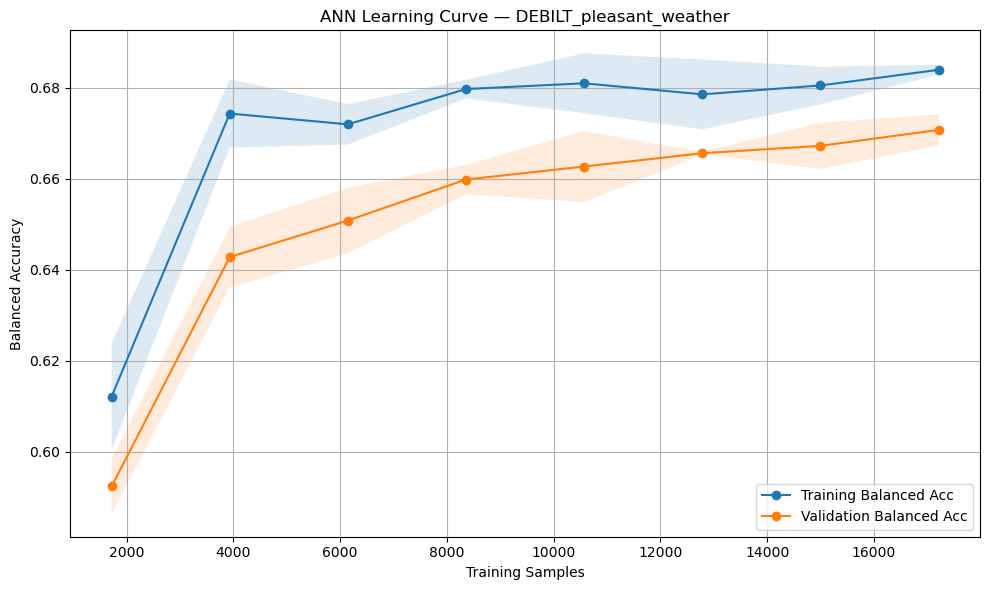

In [132]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="DEBILT_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Dusseldorf weather station with the Keras evaluate function

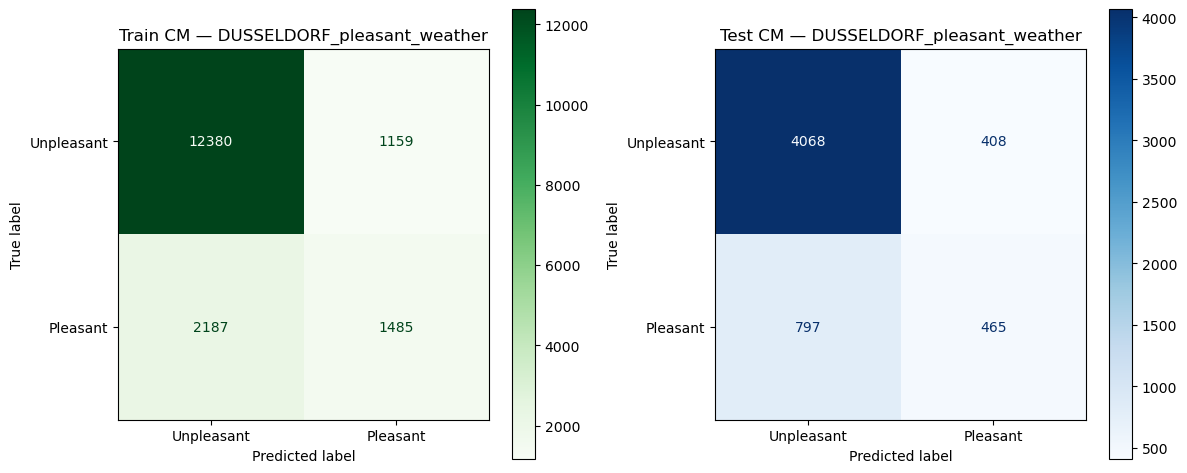

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.805589,0.659404,0.404412,0.561649,0.470234,0.914395,0.849866,1485,1159,12380,2187
Test,0.789997,0.638655,0.368463,0.532646,0.435597,0.908847,0.836177,465,408,4068,797


In [135]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_dusseldorf_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="DUSSELDORF_pleasant_weather",
    thresh=0.5
)
keras_metrics_dusseldorf_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

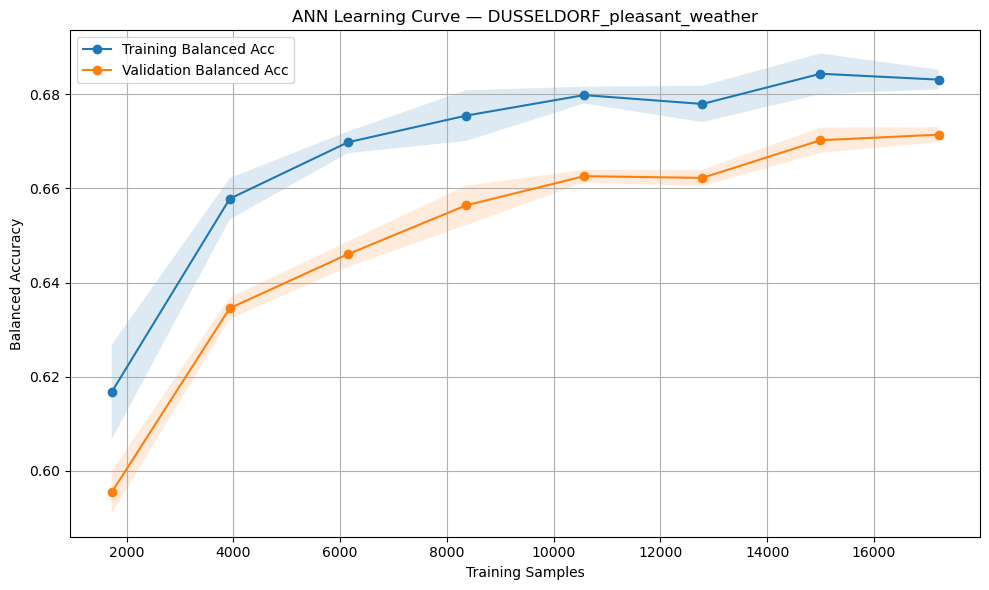

In [137]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="DUSSELDORF_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate MunchenB weather station with the Keras evaluate function

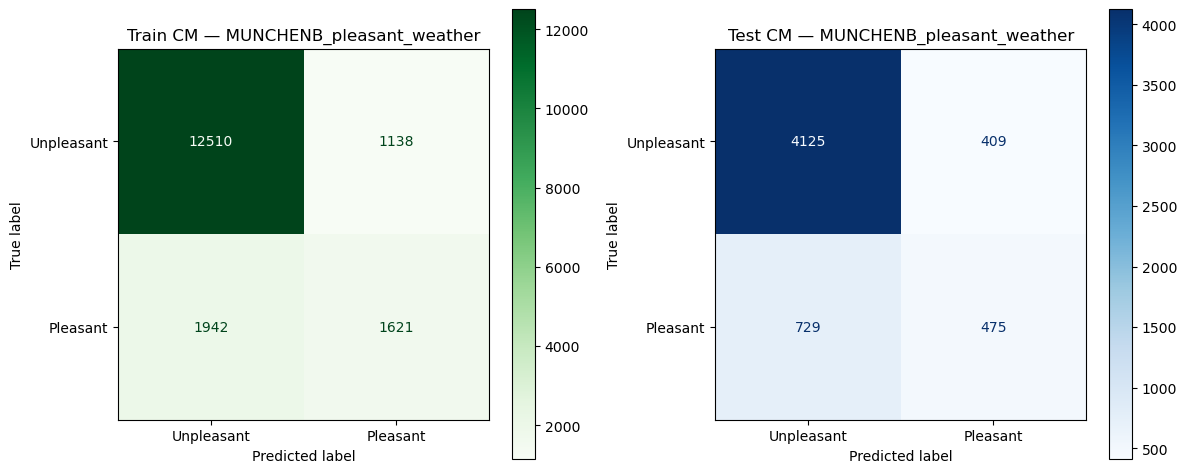

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.821045,0.685786,0.454954,0.587532,0.512812,0.916618,0.865624,1621,1138,12510,1942
Test,0.801673,0.652155,0.394518,0.537330,0.454981,0.909793,0.849815,475,409,4125,729


In [140]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_munchenb_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="MUNCHENB_pleasant_weather",
    thresh=0.5
)
keras_metrics_munchenb_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

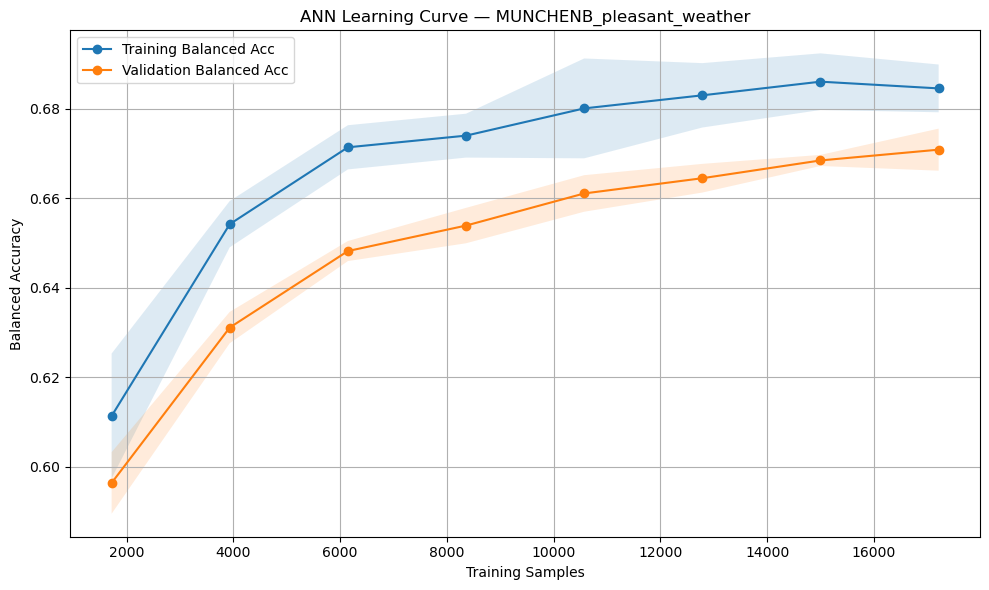

In [142]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="MUNCHENB_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Madrid weather station with the Keras evaluate function

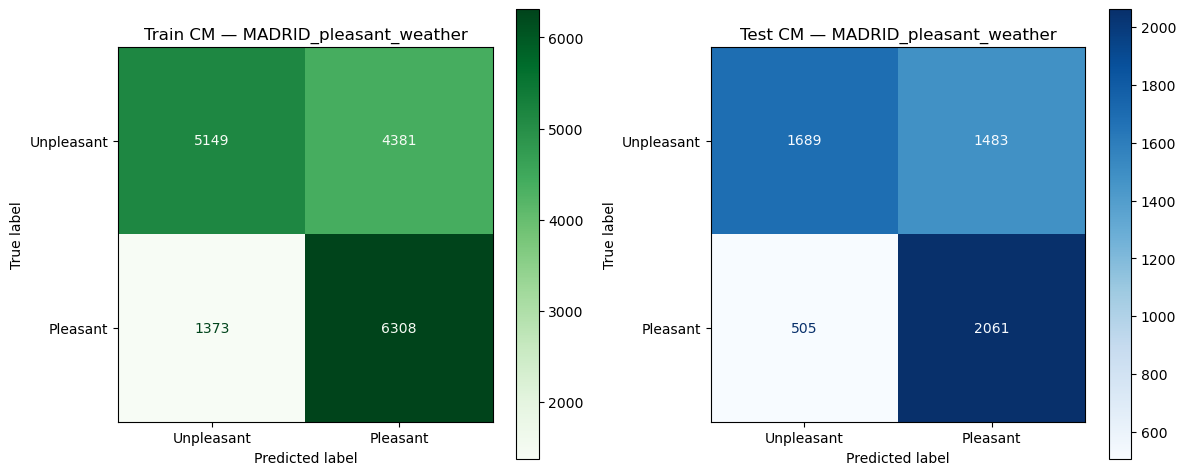

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.665679,0.680771,0.821247,0.590139,0.686772,0.540294,0.789482,6308,4381,5149,1373
Test,0.653538,0.667834,0.803196,0.581546,0.674632,0.532472,0.769827,2061,1483,1689,505


In [144]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_madrid_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="MADRID_pleasant_weather",
    thresh=0.5
)
keras_metrics_madrid_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

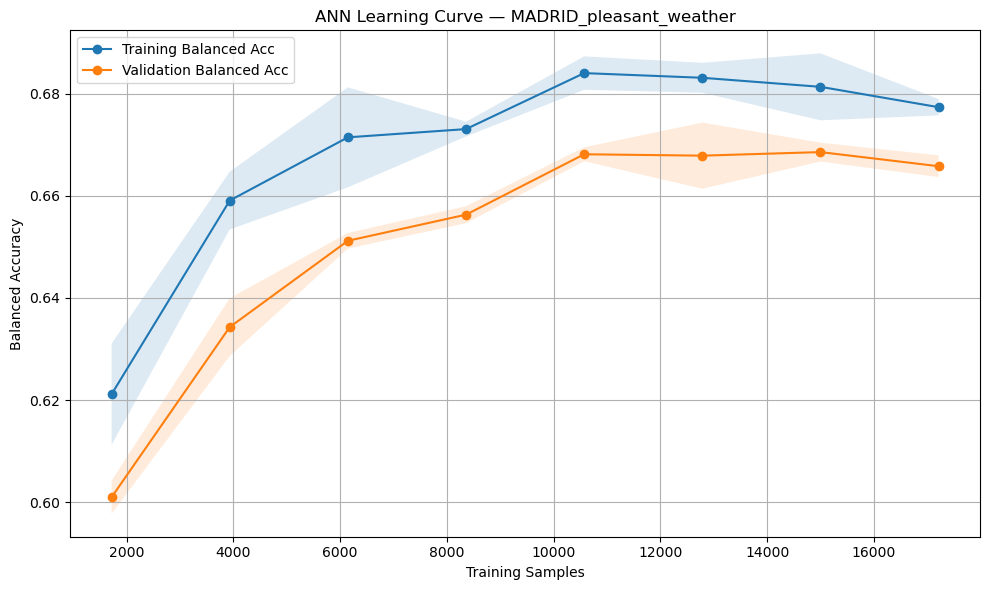

In [147]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="MADRID_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Belgrade weather station with the Keras evaluate function

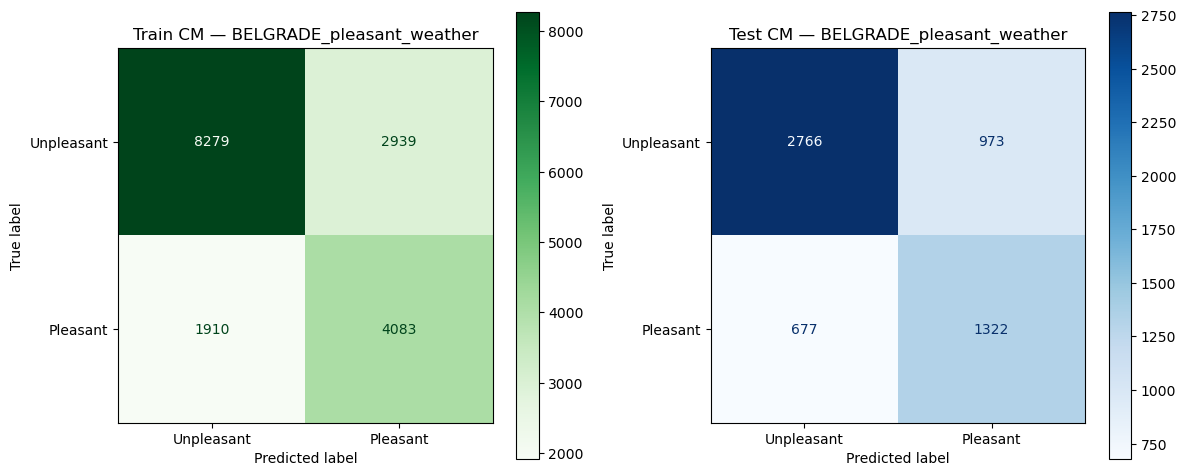

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.718262,0.709653,0.681295,0.581458,0.627430,0.73801,0.812543,4083,2939,8279,1910
Test,0.712443,0.700550,0.661331,0.576035,0.615743,0.73977,0.803369,1322,973,2766,677


In [149]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_belgrade_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="BELGRADE_pleasant_weather",
    thresh=0.5
)
keras_metrics_belgrade_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

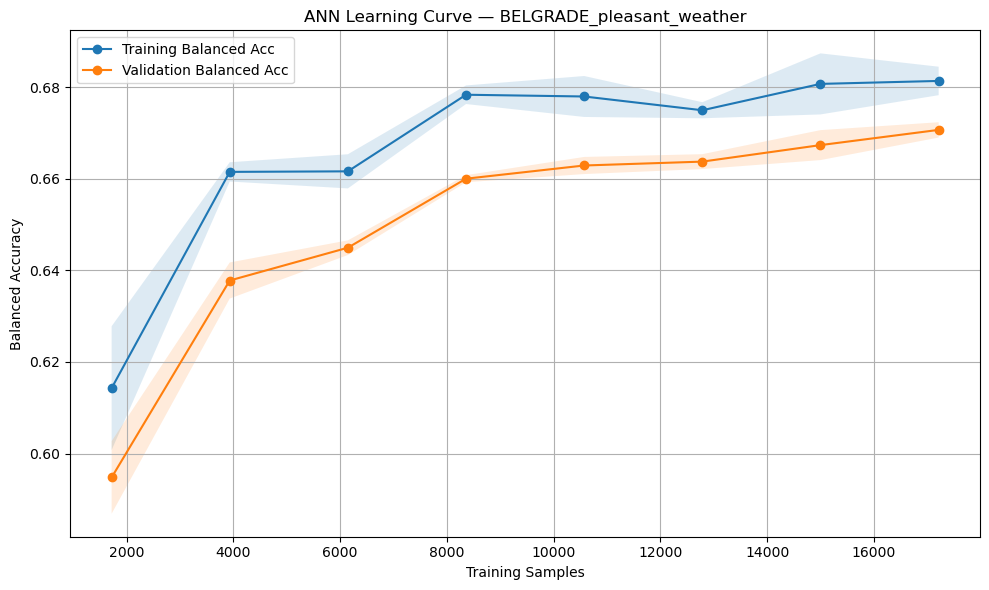

In [152]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="BELGRADE_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Ljubljana weather station with the Keras evaluate function

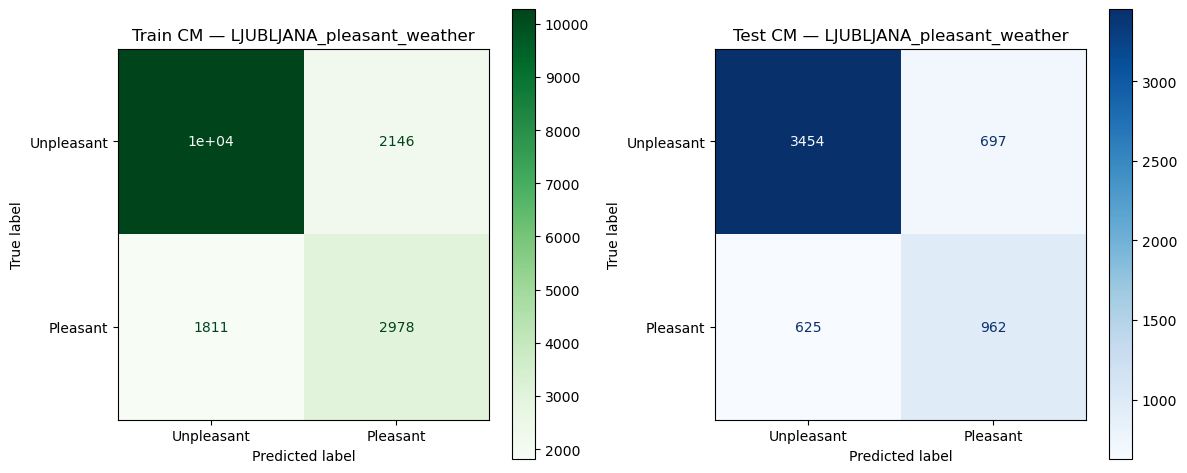

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.770089,0.724542,0.621842,0.581187,0.600827,0.827242,0.850170,2978,2146,10276,1811
Test,0.769606,0.719132,0.606175,0.579867,0.592730,0.832089,0.846776,962,697,3454,625


In [155]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_ljubljana_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="LJUBLJANA_pleasant_weather",
    thresh=0.5
)
keras_metrics_ljubljana_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

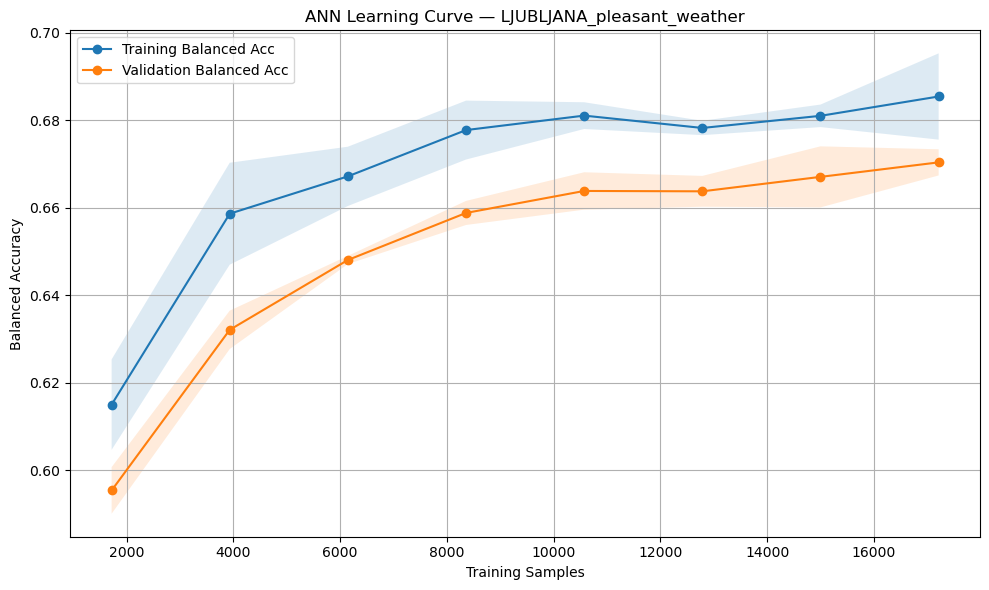

In [157]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="LJUBLJANA_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Heathrow weather station with the Keras evaluate function

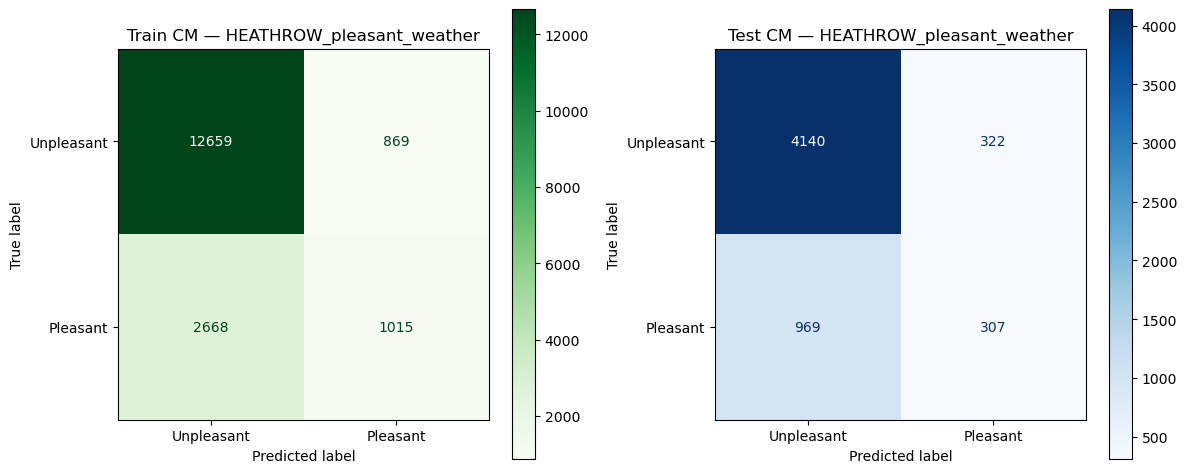

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.794492,0.605677,0.275591,0.538747,0.364649,0.935763,0.825928,1015,869,12659,2668
Test,0.775009,0.584215,0.240596,0.488076,0.322310,0.927835,0.810335,307,322,4140,969


In [160]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_heathrow_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="HEATHROW_pleasant_weather",
    thresh=0.5
)
keras_metrics_heathrow_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

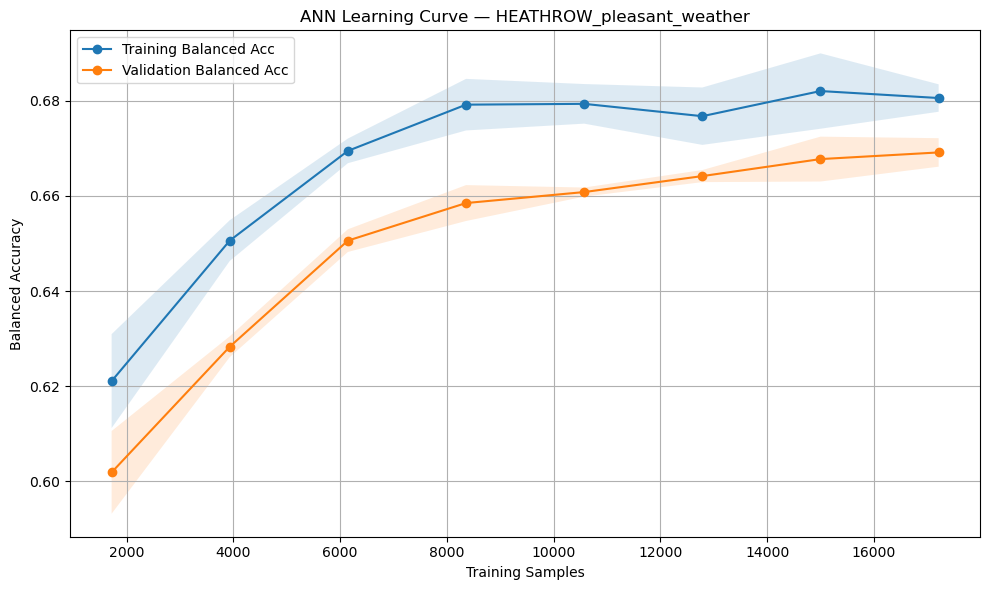

In [162]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="HEATHROW_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

#### Evaluate Maastricht weather station with the Keras evaluate function

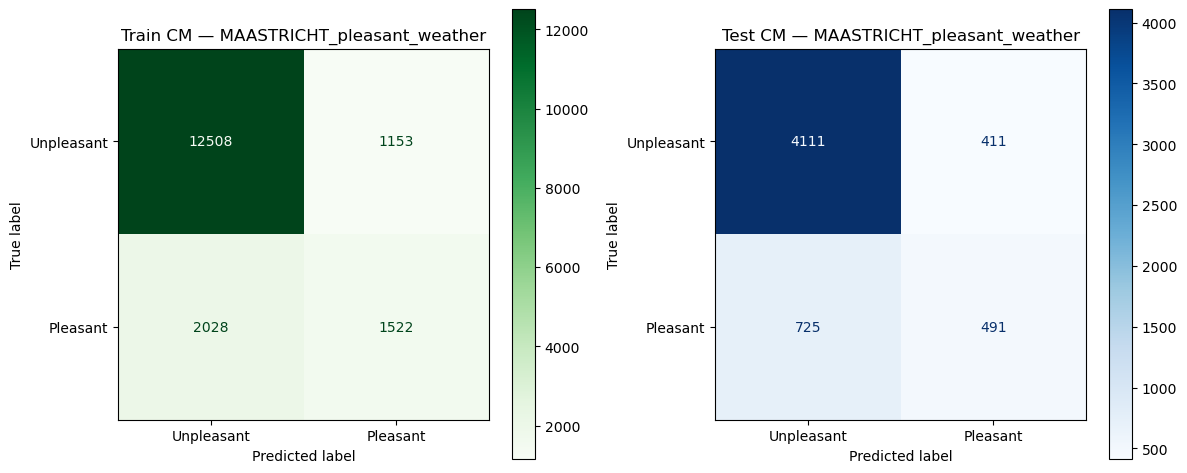

,Overall Accuracy,Balanced Accuracy,Pleasant Recall,Pleasant Precision,Pleasant F1,Unpleasant Recall (Specificity),Unpleasant Precision,TP,FP,TN,FN
Dataset,,,,,,,,,,,
Train,0.815176,0.672166,0.428732,0.568972,0.488996,0.915599,0.860484,1522,1153,12508,2028
Test,0.802022,0.656447,0.403783,0.544346,0.463645,0.909111,0.850083,491,411,4111,725


In [165]:
X_test_reduced = X_test[X_train_reduced.columns]
keras_metrics_maastricht_weighted = evaluate_keras_per_station(
    best_model_fine,
    X_train_reduced, y_train,
    X_test_reduced,  y_test,
    station_column="MAASTRICHT_pleasant_weather",
    thresh=0.5
)
keras_metrics_maastricht_weighted

#### Plot the train/test learning curves to assess overfit, underfit or acceptable fit

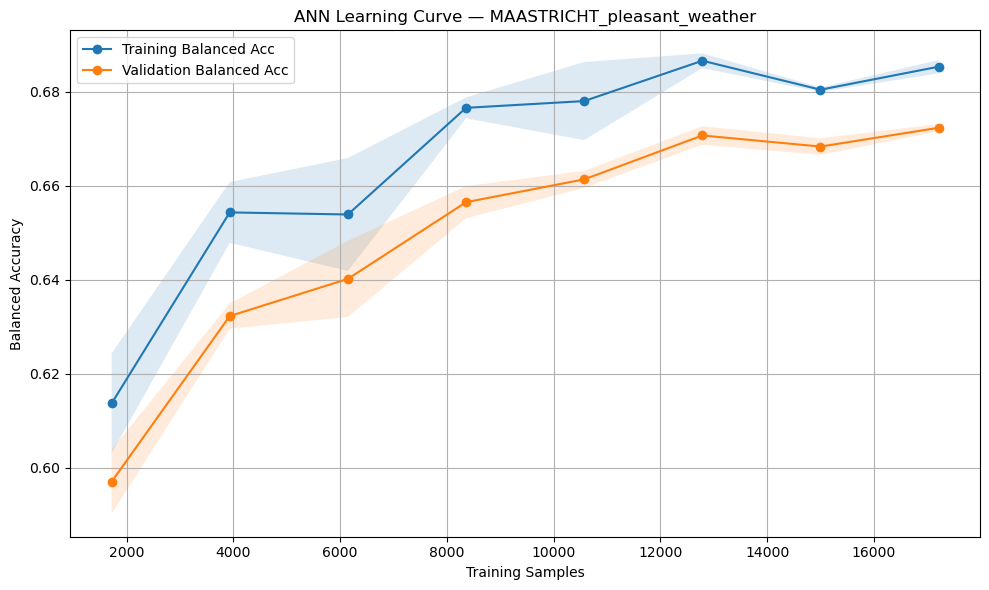

In [167]:
best_cfg_plot = {
    "hidden_units": (40,),
    "dropout": 0.1,
    "l2": 1e-3,
    "lr": 1e-3
}

_ = plot_keras_learning_curve_station(
    X=X_train_reduced,
    y_df=y_train,
    station_col="MAASTRICHT_pleasant_weather",
    build_params=best_cfg_plot,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv_splits=3,
    epochs=200,       # bump if wanted, early stopping will cap it
    batch_size=256
)

### Comment: A separate "ML Task 1.5 part 2 - Summary Results - DT vs ANN models" .ipynb notebook summarizes and compares results from both models in table form.  Sonnblick weather station, with its extreme class imbalance (100% Unpleasant days, 0% Pleasant days over 60+ years) and 100% prediction accuracy on earlier iterations of the models, is omitted from the analysis to avoid distorting results. The relevance and usefulness of the Sonnblick weather station data, for most of the ClimateWins project objectives, is also questionable.